In [1]:
import pandas as pd
import numpy as np
import os
import sys

# Add path to import EquiBoots
script_path = os.path.abspath("../py_scripts")
print("Appending path:", script_path)
sys.path.append(script_path)

Appending path: /Users/afunnell/Code/equiboots/py_scripts


In [2]:
import equiboots as eqb

from equiboots.tables import metrics_table

In [3]:
import numpy as np
import pandas as pd

def generate_biased_synthetic_data(n_samples=1000, bias_strength='moderate', random_seed=42):
    """
    Generate synthetic data with intentional bias to create statistically significant differences.
    
    Parameters:
    - n_samples: Number of samples to generate
    - bias_strength: 'mild', 'moderate', or 'strong' - controls the level of bias
    - random_seed: For reproducibility
    """
    np.random.seed(random_seed)
    
    # Define bias parameters based on strength
    bias_params = {
        'mild': {'race_bias': 0.15, 'sex_bias': 0.08, 'noise_level': 0.3},
        'moderate': {'race_bias': 0.25, 'sex_bias': 0.15, 'noise_level': 0.2},
        'strong': {'race_bias': 0.4, 'sex_bias': 0.25, 'noise_level': 0.1}
    }
    
    params = bias_params[bias_strength]
    
    # Generate demographic variables
    race = np.random.choice(["white", "black", "asian", "hispanic"], n_samples, 
                           p=[0.4, 0.3, 0.15, 0.15]).reshape(-1, 1)
    sex = np.random.choice(["M", "F"], n_samples, p=[0.5, 0.5]).reshape(-1, 1)
    
    # Create bias mappings
    race_bias_map = {
        "white": 0.0,      # baseline
        "black": -params['race_bias'],    # disadvantaged
        "asian": params['race_bias'] * 0.5,  # slight advantage
        "hispanic": -params['race_bias'] * 0.7  # disadvantaged
    }
    
    sex_bias_map = {
        "M": params['sex_bias'] * 0.5,   # slight advantage
        "F": -params['sex_bias'] * 0.5   # slight disadvantage
    }
    
    # Generate base probabilities with bias
    base_prob = 0.5  # neutral starting point
    
    # Apply demographic biases
    race_adjustments = np.array([race_bias_map[r[0]] for r in race])
    sex_adjustments = np.array([sex_bias_map[s[0]] for s in sex])
    
    # Combine biases with some noise
    noise = np.random.normal(0, params['noise_level'], n_samples)
    
    # Calculate biased probabilities
    y_prob = base_prob + race_adjustments + sex_adjustments + noise
    
    # Clip to valid probability range
    y_prob = np.clip(y_prob, 0.01, 0.99)
    
    # Generate predictions and true labels based on biased probabilities
    y_pred = (y_prob > 0.5).astype(int)
    
    # Make true labels correlated with the biased probabilities to simulate real bias
    # Add some randomness to make it realistic
    true_label_prob = y_prob * 0.8 + np.random.uniform(0, 0.4, n_samples)
    true_label_prob = np.clip(true_label_prob, 0.01, 0.99)
    y_true = np.random.binomial(1, true_label_prob)
    
    return y_true, y_prob, y_pred, race, sex



In [4]:
y_true, y_prob, y_pred, race, sex = generate_biased_synthetic_data(
    n_samples=1000, 
    bias_strength='moderate',  # Try 'mild', 'moderate', or 'strong'
    random_seed=42
)

# Create fairness DataFrame
fairness_df = pd.DataFrame(
    data=np.concatenate((race, sex), axis=1), 
    columns=["race", "sex"]
)


# Initialize and process groups
eq = eqb.EquiBoots(
    y_true=y_true,
    y_prob=y_prob,
    y_pred=y_pred,
    fairness_df=fairness_df,
    fairness_vars=["race", "sex"],
)
eq.grouper(groupings_vars=["race", "sex"])

Groups created


In [5]:
sliced_race_data = eq.slicer("race")
race_metrics = eq.get_metrics(sliced_race_data)

sliced_sex_data = eq.slicer("sex")
sex_metrics = eq.get_metrics(sliced_sex_data)

In [6]:
test_config = {
    "test_type": "chi_square",
    "alpha": 0.05,
    "adjust_method": "bonferroni",
    "confidence_level": 0.95,
    "classification_task": "binary_classification",
}
stat_test_results_race = eq.analyze_statistical_significance(
    race_metrics, "race", test_config
)

stat_test_results_sex = eq.analyze_statistical_significance(
    sex_metrics, "sex", test_config
)

In [7]:
stat_test_results_race

{'omnibus': StatTestResult(statistic=224.80723962712176, p_value=8.156186456460238e-43, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.2737439433893907, confidence_interval=None),
 'hispanic': StatTestResult(statistic=58.54116074806115, p_value=4.8185506708295956e-12, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.3193557341381798, confidence_interval=None),
 'asian': StatTestResult(statistic=25.16860583529919, p_value=5.69461243607568e-05, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.21276107887062612, confidence_interval=None),
 'black': StatTestResult(statistic=111.22279329502825, p_value=2.3945705463873755e-23, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.3952363702086561, confidence_interval=None)}

In [8]:
stat_test_results_sex

{'omnibus': StatTestResult(statistic=63.913721542946405, p_value=1.7128569617157585e-13, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.252811632530915, confidence_interval=None),
 'M': StatTestResult(statistic=63.913721542946405, p_value=1.7128569617157585e-13, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.252811632530915, confidence_interval=None)}

In [9]:
overall_stat_results = {"sex": stat_test_results_sex, "race": stat_test_results_race}

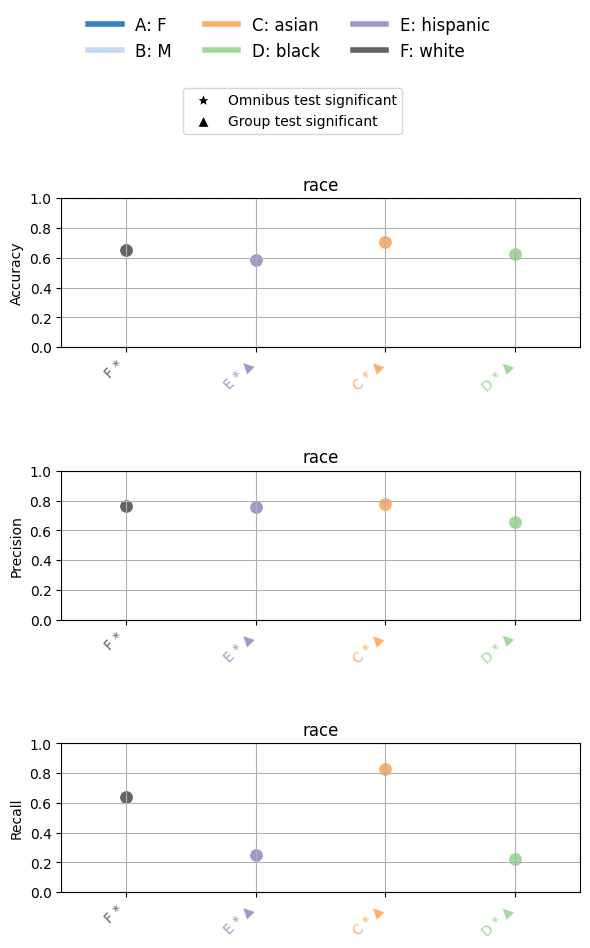

In [12]:
# Run with custom y_lim and adjusted thresholds
eqb.eq_group_metrics_point_plot(
    group_metrics=[race_metrics, sex_metrics],
    metric_cols=[
        "Accuracy",
        "Precision",
        "Recall",
    ],
    category_names=["race"],
    figsize=(6, 8),
    include_legend=True,
    plot_thresholds=(0.9, 1.1),
    raw_metrics=True,
    show_grid=True,
    y_lim=(0, 1),
    statistical_tests=overall_stat_results
)

In [11]:
is_significant_table

NameError: name 'is_significant_table' is not defined

In [ ]:
stat_test_results['omnibus'].is_significant

In [ ]:
int_list = np.linspace(0, 100, num=10, dtype=int).tolist()
eq2 = eqb.EquiBoots(
    y_true,
    y_pred,
    fairness_df,
    ["race", "sex"],
    y_prob,
    seeds=int_list,
    reference_groups=["white", "M"],
    task="binary_classification",
    bootstrap_flag=True,
    num_bootstraps=1000,
    boot_sample_size=1000,
    balanced=True,  # False is stratified, True is balanced
    # stratify_by_outcome=True,
)

# Set seeds
eq2.set_fix_seeds(int_list)
print("seeds", eq2.seeds)

eq2.grouper(groupings_vars=["race", "sex"])

boots_race_data = eq2.slicer("race")
race_metrics = eq2.get_metrics(boots_race_data)
dispa = eq2.calculate_disparities(race_metrics, "race")

In [ ]:
diffs = eq2.calculate_differences(race_metrics, "race")


In [ ]:
metrics_boot = ['Accuracy_diff', "Precision_diff", "Recall_diff"]


test_config = {
    "test_type": "bootstrap_test",
    "alpha": 0.05,
    "adjust_method": "bonferroni",
    "confidence_level": 0.95,
    "classification_task": "binary_classification",
    "tail_type": "two_tailed",
    "metrics": metrics_boot,
}

stat_test_results = eq.analyze_statistical_significance(
    race_metrics, "race", test_config, diffs
)

In [ ]:
metrics_table(race_metrics, statistical_tests=stat_test_results, differences=diffs, reference_group="white")